In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary
from tqdm import tqdm
import cv2

### Reference
https://poddeeplearning.readthedocs.io/ko/latest/CNN/Inception.v4/  
https://deep-learning-study.tistory.com/537  

### inception v4 

5x5 convolution을 적용하면 한번에 넓은 영역의 특징을 추출이 가능  
그러나 3x3 convolution을 두번에 걸쳐 연산한다면 9개의 파라미터를 가지고있으므로  
총 18개를 사용하여 5x5와 같은 결과를 얻으면서도 더 깊은 층을 형성하는것이 가능.  
크고 무거운 convolution을 여러개의 3x3으로 쪼개어   
더 깊고 가벼우면서도 구조적으로 간단한 모델을 작성  

### 비대칭적 인수분해

NxN의 커널을 1xN과 Nx1의 두 층으로 쪼갬.   
연산량이 크게 감소하는 효과

In [3]:
path = './train/train_data.csv'

df = pd.read_csv(path)
df

,filen_name,label
0,train0001.png,8
1,train0002.png,8
2,train0003.png,8
3,train0004.png,8
4,train0005.png,8
...,...,...
4995,train4996.png,6
4996,train4997.png,6
4997,train4998.png,6
4998,train4999.png,6


In [4]:
train_file_name = df['filen_name']
train_label = df['label']

# image 파일을 불러온뒤 변수에 저장
train_image = []
for file in train_file_name:
    train_image.append(Image.open('./train/' + file))
image_to_number = np.array([np.array(image).flatten() for image in train_image])


In [5]:
base_image = image_to_number.reshape(5000,28,28)

In [6]:
#del base_image
del image_to_number

(-0.5, 298.5, 298.5, -0.5)

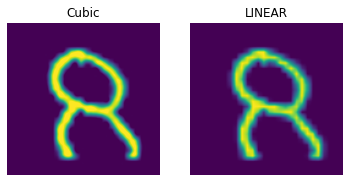

In [7]:

dst = cv2.resize(base_image[0],dsize=(299,299),interpolation=cv2.INTER_CUBIC)
dst2 = cv2.resize(base_image[0],dsize=(299,299),interpolation=cv2.INTER_LINEAR)

fig= plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(dst)
ax1.set_title('Cubic')
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(dst2)
ax2.set_title('LINEAR')
ax2.axis('off')

In [2]:
def compute_acc(true, pred):
    return sum(true == pred) / len(true)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

class MNIST(Dataset):
    def __init__(self,file_path_list,labels = None):
            self.file_path_list = file_path_list
            self.labels = labels 
            self.PIL2tensor = transforms.PILToTensor()
    def __getitem__(self,idx):
        image = Image.open(self.file_path_list[idx])
        array_image = cv2.resize(np.array(image),dsize=(299,299),interpolation = cv2.INTER_CUBIC)
        image = Image.fromarray(array_image)
        tensor_image = self.PIL2tensor(image)
        flattend_image = tensor_image.float()
        
        if self.labels is not None:
            label = self.labels[idx]
            return flattend_image, label
        
        return flattend_image
    
    def __len__(self):
        return len(self.file_path_list)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
del base_image

cuda:0 is available


NameError: name 'base_image' is not defined

In [11]:
file_path_list = './train/' + df['filen_name']
labels = df['label']

mnist_dataset = MNIST(file_path_list,labels)
mnist_loader = DataLoader(mnist_dataset,batch_size =2, shuffle = True)

### Grid 축소

연산량 감소에는 이미지 사이즈가 작아야함  
이미지 사이즈 축소 방법에는 풀링,Convoution stride의 크기 증가  

but  
first 풀링 -> 연산량은 줄어드나 정보 보존면에서 손해. 풀링에 의해 특징 맵의 정보가 손실  
first convolution -> 정보 보존은 뛰어남, 그러나 연산량이 늘어나는걸 막을수 없음  

### 해결방법
이를 해결하기 위해 고안된 병렬연산  
스트라이드2의 convolution과 함께 풀링연산이 처리됨,  
두 방식을 병렬로 적용함으로써 연산량을 줄임과 동시에 특징 맵의 정보를 잃지 않음

In [3]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, bias = False,**kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.conv(x)
        return x

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            BasicConv2d(1,32,3, stride= 2 ,padding = 0), # 13x13x32
             BasicConv2d(32,32,3, stride= 1 ,padding =0), # 11x11x 32
             BasicConv2d(32,64,3, stride= 1 ,padding = 1),# 11x11x32
        ) # 14x14x 64
        self.branch3x3_conv = BasicConv2d(64,96,3, stride=2,padding = 0)
        
        self.branch3x3_pool = nn.MaxPool2d(4, stride=2, padding=1) # 96 + 64 = 160
        self.branch7x7a = nn.Sequential(
            BasicConv2d(160,64,1,stride=1,padding = 0),
            BasicConv2d(64,64,(7,1),stride=1,padding=(3,0)),
            BasicConv2d(64,64,(1,7),stride=1,padding=(0,3)),
            BasicConv2d(64,96,3,stride=1,padding=0)
        )
        self.branch7x7b = nn.Sequential(
            BasicConv2d(160,64,1,stride=1, padding = 0),
            BasicConv2d(64,96,3,stride=1,padding = 0),
        )
        
        self.branchpoola = BasicConv2d(192,192,3, stride=2, padding = 0)
        self.branchpoolb = nn.MaxPool2d(4,2,1)
    def forward(self,x):
        x = self.conv1(x) # 22x22x64
#        x = self.branch3x3_pool(x)
        x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1) # 20x20x160
#        x = self.branch7x7b(x)
        x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)),dim=1)# 5x5x192
        x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
#         x = self.branch3x3_conv(x) 
#         print('branch3x3_conv size : ',  x.size())
#         x = self.branch3x3_pool(x)
#         print('branch3x3_pool size : ',  x.size())
        return x
net = Net()

In [8]:
model = net.to(device)
summary(model, (1,299,299), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             288
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((1,1,299,299)).float().to(device)
model = net.to(device)
output_Stem = model(x)
print('Input size:', x.size())
print('Stem output size:', output_Stem.size())

Input size: torch.Size([1, 1, 299, 299])
Stem output size: torch.Size([1, 384, 35, 35])


In [10]:
class Inception_Resnet_A(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.branch1x1 = BasicConv2d(in_channels, 32, 1, stride=1, padding=0)
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 32,1,stride = 1, padding = 0),
            BasicConv2d(32,32,3,stride = 1, padding =1)
        )
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels,32,1,stride=1,padding =0),
            BasicConv2d(32,48,3, stride=1, padding =1),
            BasicConv2d(48,64,3, stride= 1, padding =1)
        )
        self.reduction1x1 = nn.Conv2d(128,384,1,stride=1,padding =0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride = 1, padding =0)
        self.bn = nn.BatchNorm2d(384)
        self.relu = nn.ReLU()
    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x),self.branch3x3(x),self.branch3x3stack(x)),dim=1)
        x = self.reduction1x1(x)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

In [11]:
model = Inception_Resnet_A(output_Stem.size()[1]).to(device)
output_resA = model(output_Stem)
print('Input size:', output_Stem.size())
print('Stem output size:', output_resA.size())


Input size: torch.Size([1, 384, 35, 35])
Stem output size: torch.Size([1, 384, 35, 35])


Reduction -> 피쳐 맵 풀링. 맵수를 줄이거나, 늘이는데 효과가 있음

In [12]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k,l, m,n):
        super().__init__()
        
        self.branchpool = nn.MaxPool2d(3,2)
        self.branch3x3 = BasicConv2d(in_channels,n,3,stride=2,padding =0)
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, k, 1, stride=1,padding=0),
            BasicConv2d(k,l,3,stride=1,padding=1),
            BasicConv2d(l,m,3,stride=2,padding=0)
        )
        self.output_channels = in_channels + n + m
    def forward(self,x):
        x = torch.cat((self.branchpool(x),self.branch3x3(x),self.branch3x3stack(x)),dim=1)
        return x

In [13]:
print('input size:', output_resA.size())
model = ReductionA(output_resA.size()[1], 256, 256, 384, 384).to(device)
output_rA = model(output_resA)
print('output size:', output_rA.size())

input size: torch.Size([1, 384, 35, 35])
output size: torch.Size([1, 1152, 17, 17])


In [14]:
class Inception_Resnet_B(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        
        self.branch1x1 = BasicConv2d(in_channels,192,1,stride=1, padding =0)
        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 128,1,stride=1,padding=0),
            BasicConv2d(128,160,(1,7),stride=1,padding=(0,3)),
            BasicConv2d(160,192,(7,1),stride=1,padding=(3,0))
            
        )
        self.reduction1x1 = nn.Conv2d(384,1152,1,stride=1,padding=0)
        self.shortcut = nn.Conv2d(in_channels,1152,1,stride=1,padding=0)
        self.bn = nn.BatchNorm2d(1152)
        self.relu = nn.ReLU()
    def forward(self,x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x),self.branch7x7(x)),dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x+x_shortcut)
        x = self.relu(x)
        return x
    

In [15]:
# check Inception_Resnet_B
model = Inception_Resnet_B(output_rA.size()[1]).to(device)
output_resB = model(output_rA)
print('Input size:', output_rA.size())
print('output size:', output_resB.size())

Input size: torch.Size([1, 1152, 17, 17])
output size: torch.Size([1, 1152, 17, 17])


In [16]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3a = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 384, 3, stride=2, padding=0)
        )
        self.branch3x3b = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=2, padding=0)
        )
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=1, padding=1),
            BasicConv2d(288, 320, 3, stride=2, padding=0)
        )

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3a(x), self.branch3x3b(x), self.branch3x3stack(x)), dim=1)
        return x

In [17]:
model = ReductionB(output_resB.size()[1]).to(device)
output_rB = model(output_resB)
print('Input size:', output_resB.size())
print('output size:', output_rB.size())

Input size: torch.Size([1, 1152, 17, 17])
output size: torch.Size([1, 2144, 8, 8])


In [18]:
class Inception_Resnet_C(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 192, 1, stride=1, padding=0),
            BasicConv2d(192, 224, (1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, (3,1), stride=1, padding=(1,0))
        )

        self.reduction1x1 = nn.Conv2d(448, 2144, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 2144, 1, stride=1, padding=0) # 2144
        self.bn = nn.BatchNorm2d(2144)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x)), dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

In [19]:
model = Inception_Resnet_C(output_rB.size()[1]).to(device)
output_resC = model(output_rB)
print('Input size:', output_rB.size())
print('output size:', output_resC.size())

Input size: torch.Size([1, 2144, 8, 8])
output size: torch.Size([1, 2144, 8, 8])


In [20]:
class InceptionResNetV2(nn.Module):
    def __init__(self, A, B, C, k=256, l=256, m=384, n=384, num_classes=10, init_weights=True):
        super().__init__()
        blocks = []
        blocks.append(Net())
        for i in range(A):
            blocks.append(Inception_Resnet_A(384))
        blocks.append(ReductionA(384, k, l, m, n))
        for i in range(B):
            blocks.append(Inception_Resnet_B(1152))
        blocks.append(ReductionB(1152))
        for i in range(C):
            blocks.append(Inception_Resnet_C(2144))

        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # drop out
        self.dropout = nn.Dropout2d(0.2)
        self.linear = nn.Linear(2144, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [27]:
model = InceptionResNetV2(10, 20, 10).to(device)
summary(model, (1, 299, 299), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             288
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

     BatchNorm2d-706          [-1, 192, 17, 17]             384
            ReLU-707          [-1, 192, 17, 17]               0
     BasicConv2d-708          [-1, 192, 17, 17]               0
          Conv2d-709         [-1, 1152, 17, 17]         443,520
     BatchNorm2d-710         [-1, 1152, 17, 17]           2,304
            ReLU-711         [-1, 1152, 17, 17]               0
Inception_Resnet_B-712         [-1, 1152, 17, 17]               0
          Conv2d-713         [-1, 1152, 17, 17]       1,328,256
          Conv2d-714          [-1, 192, 17, 17]         221,184
     BatchNorm2d-715          [-1, 192, 17, 17]             384
            ReLU-716          [-1, 192, 17, 17]               0
     BasicConv2d-717          [-1, 192, 17, 17]               0
          Conv2d-718          [-1, 128, 17, 17]         147,456
     BatchNorm2d-719          [-1, 128, 17, 17]             256
            ReLU-720          [-1, 128, 17, 17]               0
     BasicConv2d-721          [-1, 128

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(net.parameters(), lr=1e-5)
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer,mode = 'min',factor = 0.1, patience=10)

In [52]:
from tqdm import tqdm

for Epoch in tqdm(range(5)):
    for batch, labels in mnist_loader:
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        output = model(batch)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        acc = compute_acc(labels.detach().cpu().numpy(), output.detach().cpu().numpy().argmax(-1))
        
    if Epoch % 10 == 0 or Epoch == 29:
        print(f'Epoch {Epoch}, loss : {loss}, acc : {acc}')

 20%|████████████████                                                                | 1/5 [19:19<1:17:19, 1159.92s/it]

Epoch 0, loss : 5.017549514770508, acc : 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:40:39<00:00, 1207.97s/it]


In [55]:
torch.save(model.state_dict(),'model.pt')

In [21]:
test_model = InceptionResNetV2(10, 20, 10).to(device)
test_model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [51]:
import gc`
gc.collect()
torch.cuda.empty_cache()

In [23]:
test_df = pd.read_csv('./test/test_data.csv') 
test_file_dir = './test/'

In [24]:
test_mnist_dataset = MNIST(test_file_dir + test_df['file_name'])
test_mnist_loader = DataLoader(test_mnist_dataset, batch_size = 4)
preds = None

for test_batch in tqdm(test_mnist_loader):
    test_batch = test_batch.to(device)
    output = test_model(test_batch)
    
    digit_pred = output.detach().cpu().numpy().argmax(-1)
    if preds is None:
        preds = digit_pred
    else:
        preds = np.concatenate([preds,digit_pred])
        

100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:18<00:00,  3.93it/s]


In [28]:
submission = pd.read_csv('./sample_submission.csv') # sample submission 불러오기

submission['label'] = preds

submission.to_csv('submission.csv', index=False)